In [2]:
# Installation of Required Dependencies
!pip install -U git+https://github.com/filippo-merlo/LLaVA-NeXT.git
#!pip install -U bitsandbytes
#!pip install flash-attn --no-build-isolation
#!pip install -U transformers

  Cloning https://github.com/filippo-merlo/LLaVA-NeXT.git to /tmp/pip-req-build-bockb00k
  Running command git clone --filter=blob:none --quiet https://github.com/filippo-merlo/LLaVA-NeXT.git /tmp/pip-req-build-bockb00k
  Resolved https://github.com/filippo-merlo/LLaVA-NeXT.git to commit e1330103117a0def364e74338a4ee4d573be5a4a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for llava: filename=llava-1.7.0.dev0-py3-none-any.whl size=328230 sha256=e002a4f41422d3001ab0b545ca45cf3f8e47e1fa6a53cacf070ed23eea563fef
  Stored in directory: /tmp/pip-ephem-wheel-cache-61xt6k4j/wheels/77/a1/97/baacdb566a006d2f6dc2ccdf1691f7f6ed6add2df68791d91a
Successfully built llava
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.3 MB/s eta

In [3]:
# Importing Required Libraries and Modules
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image
from pprint import pprint
import copy
from io import BytesIO
import requests
import json
import torch
import torch.nn.functional as F

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import process_images, tokenizer_image_token, get_model_name_from_path

from typing import Dict
from functools import partial, reduce
from PIL import Image
from transformers.image_processing_utils import get_size_dict
from transformers.image_transforms import (
    convert_to_rgb,
    normalize,
    rescale,
    resize,
    to_channel_dimension_format,
)
from transformers.image_utils import ChannelDimension, to_numpy_array, PILImageResampling
from transformers.utils import ModelOutput

Please install pyav to use video processing functions.
OpenCLIP not installed


tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

In [3]:
# Utility Functions for Image Processing and Bounding Box Manipulation
def add_grey_background_and_rescale_bbox(image_path, bbox):
    """
    Adds a grey square background to the input image, centers the image on it,
    and rescales the bounding box to correspond to the new image dimensions.

    Args:
        image_path (ster): Path to input image.
        bbox (tuple): A tuple describing the bounding box in the format (x, y, w, h).

    Returns:
        PIL.Image.Image: The new image with a grey background.
        tuple: The rescaled bounding box in the format (x, y, w, h).
    """
    image = Image.open(image_path)

    # Unpack the bounding box
    x, y, w, h = bbox

    # Determine the size of the new square background
    max_dim = max(image.width, image.height)
    new_size = (max_dim, max_dim)

    # Create a new grey background image
    grey_background = Image.new("RGB", new_size, color=(128, 128, 128))

    # Calculate the position to center the original image
    offset_x = (max_dim - image.width) // 2
    offset_y = (max_dim - image.height) // 2

    # Paste the original image onto the grey background
    grey_background.paste(image, (offset_x, offset_y))

    # Rescale the bounding box to the new image dimensions
    new_bbox = (x + offset_x, y + offset_y, w, h)

    return grey_background, new_bbox

def add_gaussian_noise_in_bbox(image, bbox, noise_level=0.0):

    # Add noise to the image within the bounding box
    image_np = np.array(image)

    # Box notation [x, y, w, h]
    x, y, w, h = map(int, bbox)

    # Ensure the bounding box is within the image dimensions
    x_end = min(x + w, image_np.shape[1])
    y_end = min(y + h, image_np.shape[0])

    # Extract the region of interest
    roi = image_np[y:y_end, x:x_end]

    # Generate Gaussian noise
    noise = np.random.normal(loc=0, scale=255*noise_level, size=roi.shape)

    # Add noise to the region of interest
    noisy_roi = roi + noise

    # Clip values to be valid pixel values
    noisy_roi = np.clip(noisy_roi, 0, 255).astype(np.uint8)

    # Replace the original region with the noisy one
    image_np[y:y_end, x:x_end] = noisy_roi

    # Convert back to PIL Image
    noisy_image = Image.fromarray(image_np)

    return noisy_image

def add_gaussian_noise_outside_bbox(image, bbox, noise_level=0.0):
    """
    Adds Gaussian noise to an image only outside the specified bounding box.

    Parameters:
        image (PIL.Image.Image): Input image.
        bbox (tuple): Bounding box in the format (x, y, w, h).
        noise_level (float): The standard deviation of the Gaussian noise as a fraction of the intensity range (0-1).

    Returns:
        PIL.Image.Image: Image with Gaussian noise applied outside the bounding box.
    """
    # Convert the image to a numpy array
    image_np = np.array(image)

    # Extract the bounding box coordinates
    x, y, w, h = map(int, bbox)
    x_end = min(x + w, image_np.shape[1])
    y_end = min(y + h, image_np.shape[0])

    # Create a mask for the bounding box region
    mask = np.zeros_like(image_np, dtype=bool)
    mask[y:y_end, x:x_end] = True

    # Generate Gaussian noise
    noise = np.random.normal(loc=0, scale=255 * noise_level, size=image_np.shape)

    # Apply noise only where the mask is False (outside the bbox)
    noisy_image_np = np.where(mask, image_np, image_np + noise)

    # Clip pixel values to ensure they are valid
    noisy_image_np = np.clip(noisy_image_np, 0, 255).astype(np.uint8)

    # Convert the numpy array back to a PIL Image
    noisy_image = Image.fromarray(noisy_image_np)

    return noisy_image

# Normalize box diamentions
def normalize_box(bbox, image_width=1025, image_height=1025):
    return (
        round(float(bbox[0] / image_width), 4),
        round(float(bbox[1] / image_height), 4),
        round(float(bbox[2] / image_width), 4),
        round(float(bbox[3] / image_height), 4),
    )

def convert_box(bbox):
    x, y, w, h = tuple(bbox) # Box coordinates are in (left, top, width, height) format
    return [x, y, x+w, y+h]

In [4]:
# Attention Processing and Image Handling Utilities

# many are copied from https://github.com/mattneary/attention/blob/master/attention/attention.py
# here it nullifies the attention over the first token (<bos>)
# which in practice we find to be a good idea

def aggregate_llm_attention(attn):
    '''Extract average attention vector'''
    avged = []
    for layer in attn:
        layer_attns = layer.squeeze(0)
        attns_per_head = layer_attns.mean(dim=0)
        vec = torch.concat((
            # We zero the first entry because it's what's called
            # null attention (https://aclanthology.org/W19-4808.pdf)
            torch.tensor([0.]),
            # usually there's only one item in attns_per_head but
            # on the first generation, there's a row for each token
            # in the prompt as well, so take [-1]
            attns_per_head[-1][1:].cpu(),
        ))
        avged.append(vec / vec.sum())
    return torch.stack(avged).mean(dim=0)

def heterogenous_stack(vecs):
    '''Pad vectors with zeros then stack'''
    max_length = max(v.shape[0] for v in vecs)
    return torch.stack([
        torch.concat((v, torch.zeros(max_length - v.shape[0])))
        for v in vecs
    ])

def aggregate_vit_attention(attn, select_layer=-2):
    layer = attn[select_layer]
    layer_attns = layer.squeeze(0)
    attns_per_head = layer_attns.mean(dim=0).cpu()
    return attns_per_head / attns_per_head.sum(-1, keepdim=True)

# subtract mean layer activation
def aggregate_vit_attention_subtract_avg(attn, attn_avg, select_layer=-2, all_prev_layers=True):
    """
    Highlights layer-specific attention by subtracting the average attention across all layers
    and ensures the results are non-negative (only positive values or 0).
    Parameters:
        attn: List of attention maps, one per layer. Each map is of shape (batch_size, num_heads, num_tokens, num_tokens).
        select_layer: Layer index to process (-2 by default, assuming LLaVA-style).
        all_prev_layers: If True, considers all layers up to `select_layer`; otherwise, processes only the specified layer.
    Returns:
        Adjusted attention maps for each layer after removing the average attention across all layers.
    """
    avged = []

    # Step 2: Subtract average attention from each layer and apply ReLU
    for i, layer in enumerate(attn):
        if all_prev_layers and i > len(attn) + select_layer:
            break
        layer_attns = layer.squeeze(0)
        attns_per_head = layer_attns.mean(dim=0)
        vec = attns_per_head[0:, 0:].cpu()
        vec_normalized = vec / vec.sum(-1, keepdim=True)
        # Subtract the average attention and apply ReLU to ensure non-negative values
        adjusted_attention = torch.relu(vec_normalized - attn_avg[i])
        avged.append(adjusted_attention)

    if all_prev_layers:
        return torch.stack(avged)  # Return all adjusted attention maps
    else:
        # For single layer mode, return adjusted attention for the selected layer
        selected_layer = attn[select_layer]
        layer_attns = selected_layer.squeeze(0)
        attns_per_head = layer_attns.mean(dim=0)
        vec = attns_per_head[0:, 0:].cpu()
        vec_normalized = vec / vec.sum(-1, keepdim=True)
        return torch.relu(vec_normalized - attn_avg[i])

def load_image(image_path_or_url):
    if image_path_or_url.startswith('http://') or image_path_or_url.startswith('https://'):
        response = requests.get(image_path_or_url)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_path_or_url).convert('RGB')
    return image


def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_HSV)
    hm = np.float32(heatmap) / 255
    cam = hm + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam), heatmap

In [ ]:
# ===> Specify the model path and configuration
pretrained = "lmms-lab/llava-onevision-qwen2-0.5b-si"  # Pretrained model identifier
model_name = "llava_qwen"  # Model alias
device = "cuda"  # Define the computing device (use CUDA if available)
device_map = "auto"  # Automatically map model layers to the appropriate device(s)

# Define quantization settings for model loading
load_8bit = False  # Set to True to load the model in 8-bit precision (for reduced memory usage)
load_4bit = False  # Set to True to load the model in 4-bit precision (further reducing memory usage)

# Define model arguments for LLaVA
llava_model_args = {
    "multimodal": True,  # Enable multimodal capabilities (text + vision)
    "attn_implementation": "sdpa",  # Use scalable dot-product attention for efficiency
    "load_8bit": load_8bit,  # Load model in 8-bit if enabled
    "load_4bit": load_4bit,  # Load model in 4-bit if enabled
}

# Load the pretrained model, tokenizer, and image processor
tokenizer, model, image_processor, max_length = load_pretrained_model(
    pretrained, None, model_name, device_map="auto", **llava_model_args
)

# Set model to evaluation mode (disables dropout layers)
model.eval()

# Disable PyTorch's default initialization for performance optimization
disable_torch_init()

Loaded LLaVA model: lmms-lab/llava-onevision-qwen2-0.5b-si


tokenizer_config.json:   0%|          | 0.00/1.54k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.03k [00:00<?, ?B/s]

You are using a model of type llava to instantiate a model of type llava_qwen. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/1.79G [00:00<?, ?B/s]

Loading vision tower: google/siglip-so400m-patch14-384


config.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.51G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2400: UserWarning: for vision_model.embeddings.patch_embedding.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2400: UserWarning: for vision_model.embeddings.patch_embedding.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2400: UserWarning: for vision_model.embeddings.position_embedding.weight: copying from a non-meta

generation_config.json:   0%|          | 0.00/247 [00:00<?, ?B/s]

Model Class: LlavaQwenForCausalLM


In [1]:
# Image Processing and Prompt Preparation for Object Recognition

# ===> Define noise level and condition settings
noise_level_id = 0  # Index for noise level selection
condition_id = 0  # Index for noise condition selection

# Set noise level based on predefined options
noise_level = [0.0, 0.5, 1.0][noise_level_id]

# Select noise application condition: target area, context, or entire image
condition = ['target_noise', 'context_noise', 'all_noise'][condition_id]

# ===> Load Example Image and Image Data
image_name = '000000248372_street_stop_sign_teddy_bear_relscore_low.jpg'
image_path = '/content/drive/MyDrive/evaluation_data/resized_images/000000248372_street_stop_sign_teddy_bear_relscore_low.jpg'
bbox = [69, 73, 127, 123]  # Bounding box in (x, y, width, height) format
target = 'teddy bear'  # Object of interest

# Add a grey background and rescale the bounding box to fit the new image dimensions
image, bbox = add_grey_background_and_rescale_bbox(image_path, bbox)

# Apply noise based on the selected condition
if condition == 'target_noise':
    image = add_gaussian_noise_in_bbox(image, bbox, noise_level)
elif condition == 'context_noise':
    image = add_gaussian_noise_outside_bbox(image, bbox, noise_level)
elif condition == 'all_noise':
    # Apply noise both inside and outside the bounding box
    image = add_gaussian_noise_in_bbox(image, bbox, noise_level)
    image = add_gaussian_noise_outside_bbox(image, bbox, noise_level)

# ===> Process input dimensions
image_sizes = image.size  # Get image size (width, height)
W, H = image.size  # Extract width and height

# Normalize the bounding box coordinates relative to the image dimensions
normalized_bbox = normalize_box(convert_box(bbox), W, H)
x1, y1, x2, y2 = normalized_bbox  # Extract normalized coordinates

# Display the processed image
display(image)

# ===> Convert image to tensor for model processing
image_tensor = process_images([image], image_processor, model.config)

# Convert tensor dtype to float16 and move to the specified device
image_tensor = [_image.to(dtype=torch.float16, device=device) for _image in image_tensor]

# ===> Construct the prompt for the model
conv_template = "qwen_1_5"  # Ensure the correct template is used for the model
prompt_text = (
    DEFAULT_IMAGE_TOKEN +
    f"\nWhat is the object in this part of the image [{x1}, {y1}, {x2}, {y2}]? "
    "Answer with the object's name only. No extra text."
)

# Copy and update the conversation template
conv = copy.deepcopy(conv_templates[conv_template])
conv.append_message(conv.roles[0], prompt_text)  # Add user prompt
conv.append_message(conv.roles[1], None)  # Prepare for model response

# Generate the formatted prompt
prompt = conv.get_prompt()

# Tokenize the input prompt and convert to tensor
input_ids = tokenizer_image_token(
    prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt"
).unsqueeze(0).to(device)

NameError: name 'add_grey_background_and_rescale_bbox' is not defined

Tensor shape after normalization: torch.Size([5, 3, 384, 384])


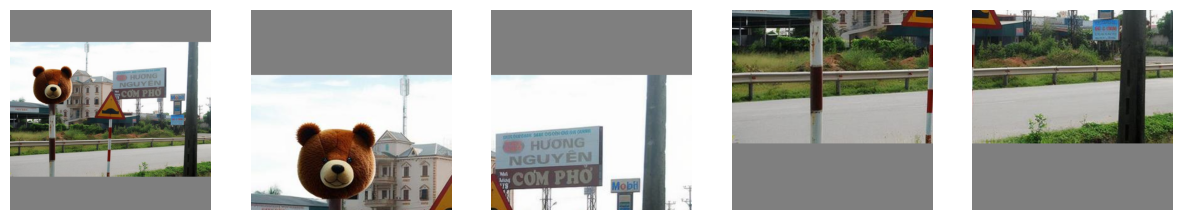

In [ ]:
# Visualization of Processed Image Tensors

# ===> Normalize the image tensor for visualization
# Assume 'image_tensor' has shape (5, 3, 384, 384) [batch_size, channels, height, width]

# Extract the first batch element (first processed image set)
tensor = image_tensor[0]

# Normalize entire tensor from [-1, 1] range to [0, 1] range
tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())

# Ensure tensor is in float32 format for visualization compatibility
tensor = tensor.to(dtype=torch.float32)

# Print shape information for debugging
print("Tensor shape after normalization:", tensor.shape)  # Expected: (5, 3, 384, 384)

# ===> Function to convert PyTorch tensor to NumPy format for visualization
def tensor_to_image(tensor):
    """
    Converts a PyTorch tensor to a NumPy image format suitable for visualization.

    Args:
        tensor (torch.Tensor): Image tensor in (C, H, W) format.

    Returns:
        np.ndarray: Converted image in (H, W, C) format.
    """
    return tensor.permute(1, 2, 0).cpu().numpy().astype("float32")  # Convert from (C, H, W) to (H, W, C)

# ===> Plot the 5 processed images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    image__ = tensor_to_image(tensor[i])  # Convert each image tensor to NumPy format
    axes[i].imshow(image__)
    axes[i].axis("off")  # Hide axes for clarity

# Display the images
plt.show()

In [ ]:
# Generate the output

with torch.inference_mode():
    outputs = model.generate(
        input_ids,
        images=image_tensor,
        image_sizes=[image_sizes],
        do_sample=False,
        temperature=0,
        max_new_tokens=4096,
        use_cache=True,
        return_dict_in_generate=True,
        output_attentions=True,
    )

text = tokenizer.decode(outputs["sequences"][0]).strip()
print(text)

vision_tower_encode: torch.Size([5, 729, 1152])
projector_encode: torch.Size([5, 729, 896])
mm_patch_merge_type: spatial_unpad
image_aspect_ratio: anyres_max_9
mm_newline_position: one_token
max_num_patches: 9
vision_tower_image_size 384
n patches: 2 2
image features pre view: torch.Size([4, 729, 896])
image features post view: torch.Size([2, 2, 27, 27, 896])
Initial image feature shape: torch.Size([2, 2, 27, 27, 896])
After permute: torch.Size([896, 2, 27, 2, 27])
After flattening: torch.Size([896, 54, 54])
After unpadding: torch.Size([896, 54, 54])
Computed downscale factor (times): 0.6666666666666666
After adding newline token: torch.Size([896, 54, 55])
Final image feature shape: torch.Size([2970, 896])
Base image feat: torch.Size([729, 896])
Cat Final image feature shape: torch.Size([3699, 896])
Batch 0 - Image Embedding Length: 3699


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:650: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.

new input embeds: torch.Size([1, 3773, 896])


Qwen2Model is using Qwen2SdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
The attention layers in this model are transitioning from computing the RoPE embeddings internally through `position_ids` (2D tensor with the indexes of the tokens), to using externally computed `position_embeddings` (Tuple of tensors, containing cos and sin). In v4.46 `position_ids` will be removed and `position_embeddings` will be mandatory.
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


Teddy bear<|im_end|>


In [2]:
# Inspecting the Vision Tower and Multimodal Projector in the Model

# ===> Access the vision tower (image encoder)
vision_tower = model.get_vision_tower()

# Print vision tower configuration details
print(f"Vision Tower Config: {vision_tower.config}")

# Compute number of patches per side (assumes square image patches)
num_patches_per_side = vision_tower.num_patches_per_side
print(f"Number of patches per side: {num_patches_per_side}")

# Check whether the "AnyRes" strategy (arbitrary resolution processing) is enabled
anyres_enabled = "anyres" in getattr(model.config, "image_aspect_ratio", "")
print(f"Using AnyRes Strategy: {anyres_enabled}")

# ===> Retrieve the multimodal projector (maps vision features to text space)
vision_projector = model.model.mm_projector
print(f"Vision Projector Type: {type(vision_projector)}")

# Check for the vision resampler (used when handling multiple images)
vision_resampler = model.model.vision_resampler
print(f"Vision Resampler Type: {type(vision_resampler)}")

# ===> Locate the vision projector module within the model
if hasattr(model.get_vision_tower(), "mm_projector"):
    vision_projector = model.get_vision_tower().mm_projector
elif hasattr(model, "vision_resampler") and hasattr(model.vision_resampler, "mm_projector"):
    vision_projector = model.vision_resampler.mm_projector
else:
    print("Could not find vision projector. Check model attributes above.")

# Search for projector modules in the model
for name, module in model.named_modules():
    if "projector" in name.lower():
        print(f"Found Vision Projector at: {name} -> {module}")

# ===> Process the image through the vision tower
print('Image_sizes:', image_sizes)

# Retrieve raw vision features from the vision tower
raw_image_features = vision_tower(image_tensor[0])  # image_tensor is a preprocessed tensor
print(f"Raw Vision Features Shape: {raw_image_features.shape}")

# Project vision features into the multimodal space
projected_features = model.model.mm_projector(raw_image_features)
print(f"Projected Vision Features Shape: {projected_features.shape}")  # Expected shape: (batch, num_tokens, 896)


NameError: name 'model' is not defined

Below we are aggregating LLM's attention aross heads and layers (simply averaging them). See the `aggregate_llm_attention` in `utils.py` for details.

In [ ]:
# Aggregating LLM Attention and Constructing the Attention Matrix

# ===> Aggregate attention scores for prompt tokens
aggregated_prompt_attention = []

# Iterate through layers of attention outputs
for i, layer in enumerate(outputs["attentions"][0]):
    layer_attns = layer.squeeze(0)  # Remove batch dimension
    attns_per_head = layer_attns.mean(dim=0)  # Average attention across heads

    cur = attns_per_head[:-1].cpu().clone()  # Clone tensor except for the last token

    # Following `aggregate_llm_attention` practice:
    # Zero out attention to the first <bos> token except for the first row
    # (since <bos> is the only token it can attend to initially)
    cur[1:, 0] = 0.
    cur[1:] = cur[1:] / cur[1:].sum(-1, keepdim=True)  # Normalize attention values

    aggregated_prompt_attention.append(cur)

# Compute the mean attention map across layers
aggregated_prompt_attention = torch.stack(aggregated_prompt_attention).mean(dim=0)

# ===> Construct the final LLM attention matrix
# llm_attn_matrix will have shape (N, N), where N = total input (image + text) and output tokens
llm_attn_matrix = heterogenous_stack(
    list(aggregated_prompt_attention)  # Add aggregated attention from prompts
    + list(map(aggregate_llm_attention, outputs["attentions"]))  # Add general LLM attention
)

# ===> Debugging prints for attention matrices
print("Size of a single attention mask:", torch.tensor([1]).size())
print("Size of aggregated prompt attention:", aggregated_prompt_attention.size())
print("Size of last attention layer output:", outputs["attentions"][0][-1].size())

# Check the attention aggregation function across different layers
for i in range(4):  # Assuming at least 4 layers exist
    print(f"Size of aggregated LLM attention at layer {i}:", aggregate_llm_attention(outputs["attentions"][i]).size())

# Print final LLM attention matrix dimensions
print("Final LLM attention matrix size:", llm_attn_matrix.size())

torch.Size([1])
torch.Size([3772, 3773])
torch.Size([1, 14, 3773, 3773])
torch.Size([3773])
torch.Size([3774])
torch.Size([3775])
torch.Size([3776])
torch.Size([3776, 3776])


In [19]:
# visualize the llm attention matrix

# ===> adjust the gamma factor to enhance the visualization
#      higer gamma brings out more low attention values
gamma_factor = 2.5
enhanced_attn_m = np.power(llm_attn_matrix[0:,0:].numpy(), 1 / gamma_factor)

fig, ax = plt.subplots(figsize=(10, 20), dpi=150)
ax.imshow(enhanced_attn_m, vmin=enhanced_attn_m.min(), vmax=enhanced_attn_m.max(), interpolation="nearest")

NameError: name 'llm_attn_matrix' is not defined

Input token length: 3772
Vision token length: 3699
Text token length: 74


First patch length: 729
First patch end index: 743


Vision token start index: 14
Vision token end index: 3713
Output token start index: 3772
Output token end index: 3776
torch.Size([3776, 3776])
torch.Size([4, 3776])
Ted
dy
bear
<|im_end|>
[0.26845958828926086, 0.4147741496562958, 0.38010019063949585, 0.34635093808174133]


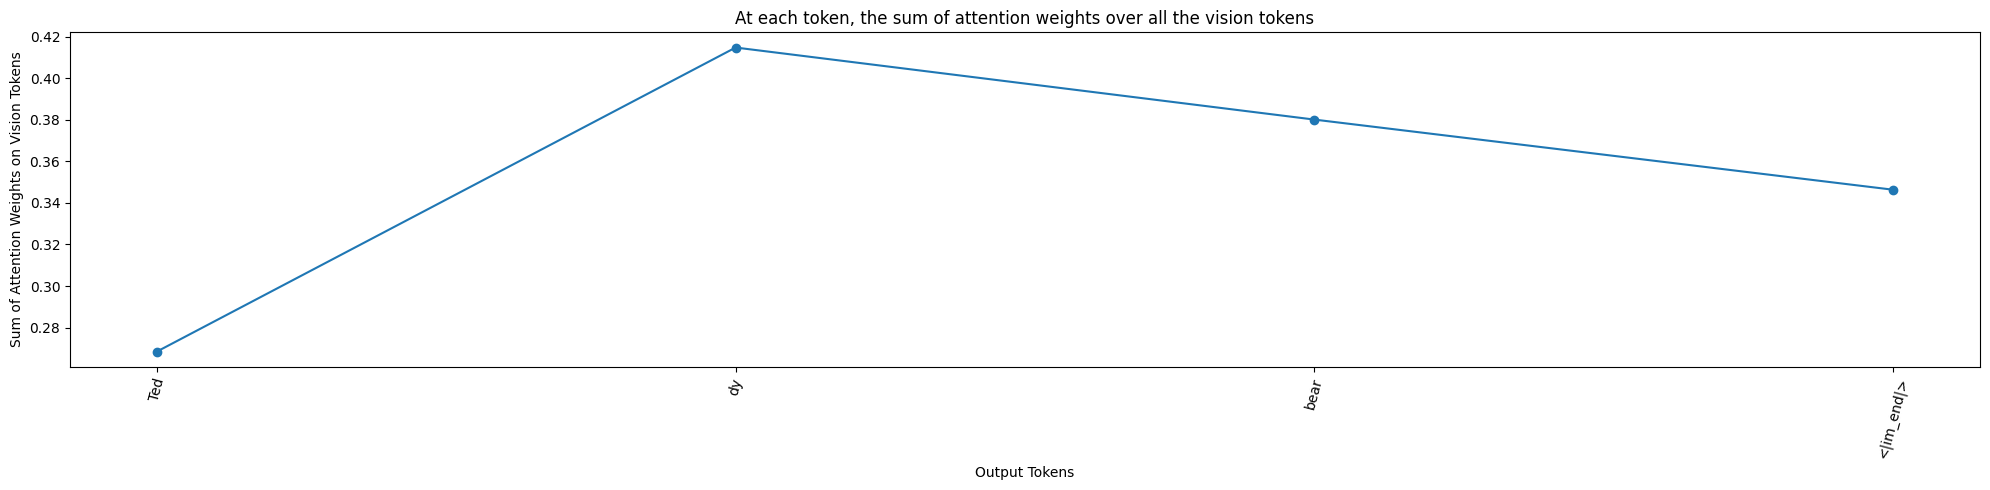

In [ ]:
# Token Length Identification

# ===> Identify token lengths
text_token_len = len(input_ids[0]) - 1  # Excluding the <image> token
input_token_len = int(outputs["attentions"][0][0][0][0][0].size(0)) - 1  # First output token count
vision_token_len = int(outputs["attentions"][0][0][0][0][0].size(0)) - text_token_len  # Extract vision token count
first_patch_len = 729  # Length of the first vision patch (assumed)

# Identify vision token start and end indices
vision_token_start = len(tokenizer(prompt.split("<image>")[0], return_tensors='pt')["input_ids"][0])
vision_token_end = vision_token_start + vision_token_len
first_patch_end = vision_token_start + first_patch_len

# Identify output token positions
output_token_len = len(outputs["sequences"][0])
output_token_start = input_token_len
output_token_end = input_token_len + output_token_len

# ===> Print token length information
print("Input token length:", input_token_len)
print("Vision token length:", vision_token_len)
print("Text token length:", text_token_len)
print("\n")
print("First patch length:", first_patch_len)
print("First patch end index:", first_patch_end)
print("\n")
print("Vision token start index:", vision_token_start)
print("Vision token end index:", vision_token_end)
print("Output token start index:", output_token_start)
print("Output token end index:", output_token_end)

# Print LLM attention matrix dimensions
print("LLM Attention Matrix Size:", llm_attn_matrix.size())
print("LLM Attention Submatrix (Output Tokens):", llm_attn_matrix[input_token_len:].size())

In [ ]:
# ===> Calculate attention weights over vision tokens for each output token
overall_attn_weights_over_vis_tokens = []

for i, (row, token) in enumerate(
    zip(
        llm_attn_matrix[input_token_len:],  # Focus on output token attention
        outputs["sequences"][0].tolist()  # Retrieve token sequence
    )
):
    print(tokenizer.decode(token, add_special_tokens=False).strip())  # Decode token for readability

    # Ensure valid vision token range
    if vision_token_start < vision_token_end:
        overall_attn_weights_over_vis_tokens.append(
            row[vision_token_start:vision_token_end].sum().item()  # Sum attention over vision tokens
        )
    else:
        raise ValueError("Invalid vision token range: vision_token_start >= vision_token_end")

# Print computed attention weights
print(overall_attn_weights_over_vis_tokens)

# ===> Plot the trend of attention weights over vision tokens
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(overall_attn_weights_over_vis_tokens, marker='o', linestyle='-')  # Add markers for better visualization
ax.set_xticks(range(len(overall_attn_weights_over_vis_tokens)))

# Label x-axis with decoded output tokens
ax.set_xticklabels(
    [tokenizer.decode(token, add_special_tokens=False).strip() for token in outputs["sequences"][0].tolist()],
    rotation=75
)

# Set plot labels and title
ax.set_xlabel("Output Tokens")
ax.set_ylabel("Sum of Attention Weights on Vision Tokens")
ax.set_title("At each output token, the sum of attention weights over all vision tokens")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [5]:
# ===> Import and load the average visual attention matrix
avg_mat_path = "path to: unzipped vis_attn_matrix_average.pt"

# Load the stored attention matrix (.pt file)
avg_mat = torch.load(avg_mat_path)

# ===> Extract attention maps from the vision tower
att_split = []
for v in model.get_vision_tower().image_attentions:
    att_split.append(v[0])  # Extract the first element of each attention map

<ipython-input-5-7f86e7352078>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  avg_mat = torch.load(avg_mat_path)


FileNotFoundError: [Errno 2] No such file or directory: 'https://drive.google.com/file/d/1byMsVqNsLgaPbCe8GFHa5nkoDvsBTLxY/view?usp=drive_link'

Below we aim to visualize the attention w.r.t. the input image. First we obtain a single attention map from the vision encoder (ViT) by again averaging the attention maps across heads and layers. I have tried a supposedly more reasonable method of [attention rollout](https://github.com/jacobgil/vit-explain/blob/main/vit_rollout.py), i.e. multiplying the attention matrices over each layer, but never got sensible results. See the `aggregate_vit_attention` in `utils.py` for details.


Then, for each generated token of LLM, we compute the weighted average of the attention map of each vision token to get an aggregated attention map over the input image for that generated token. Finally we resize and overlay the attention map on the input image.

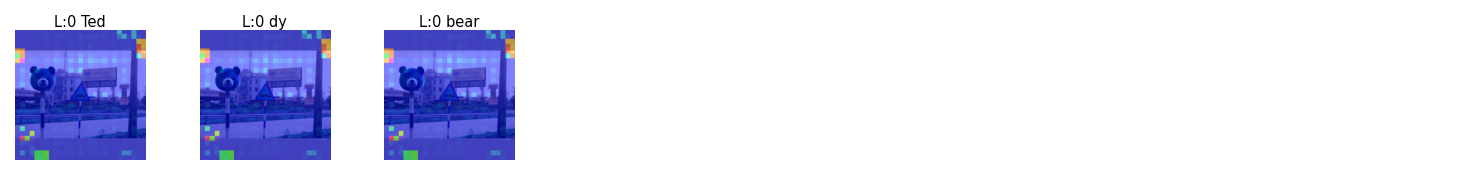

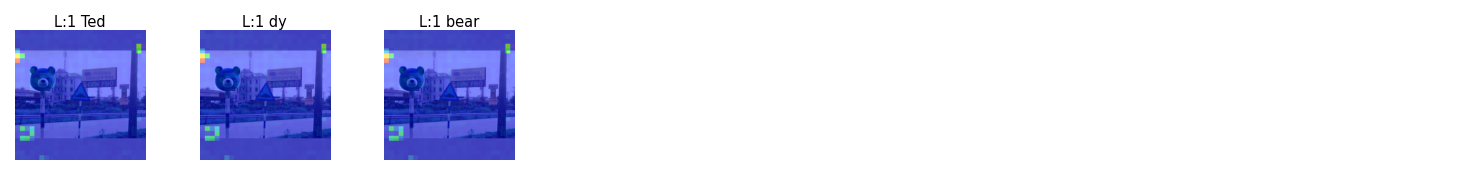

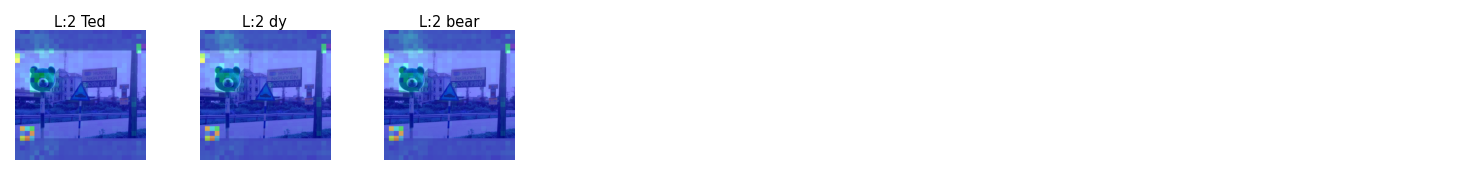

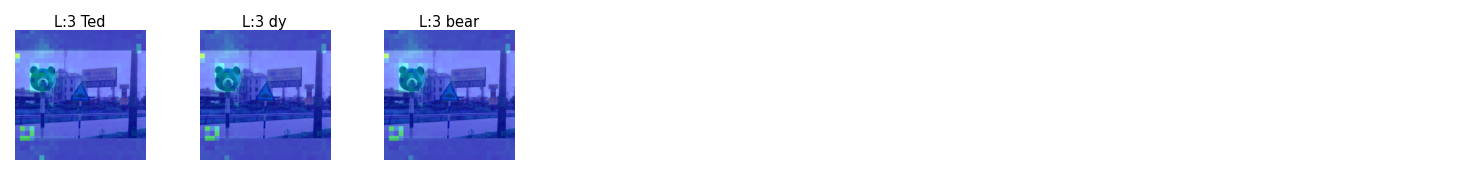

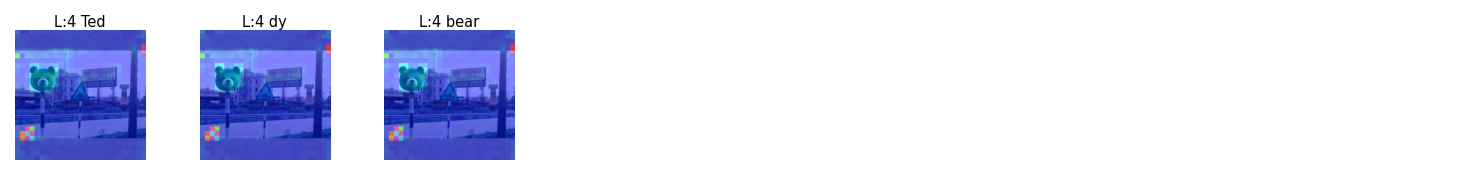

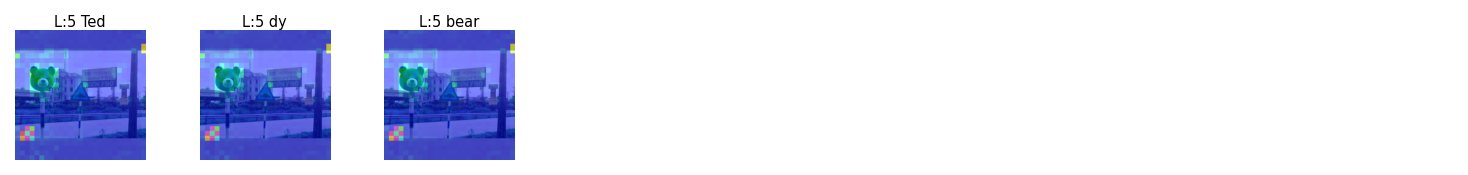

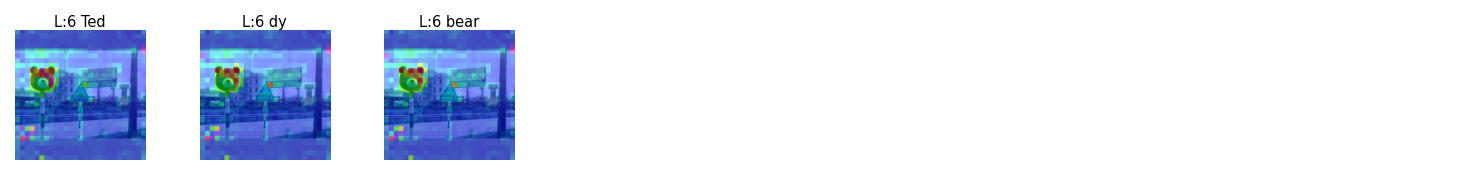

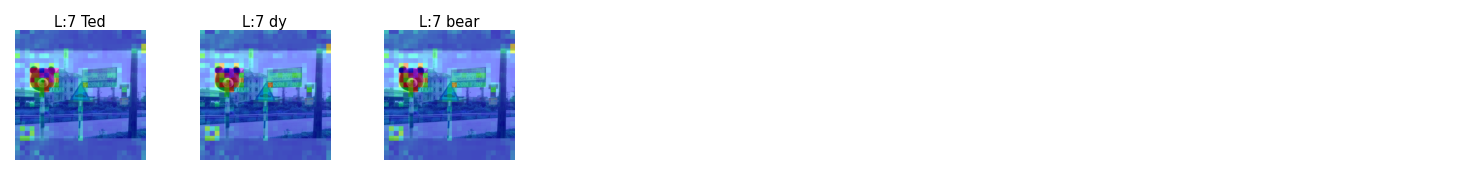

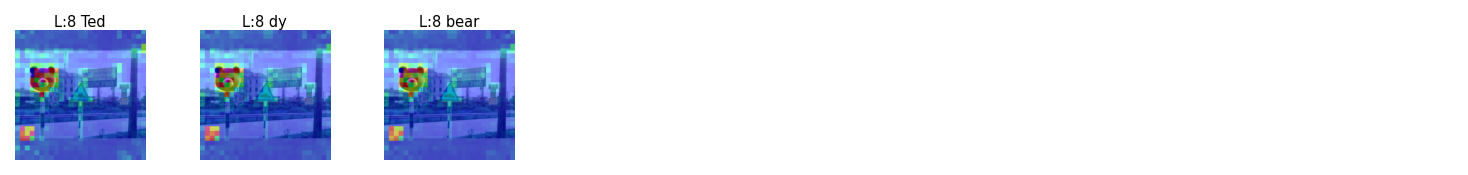

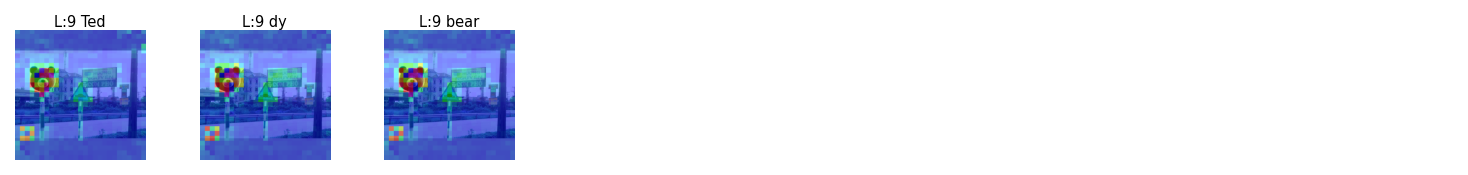

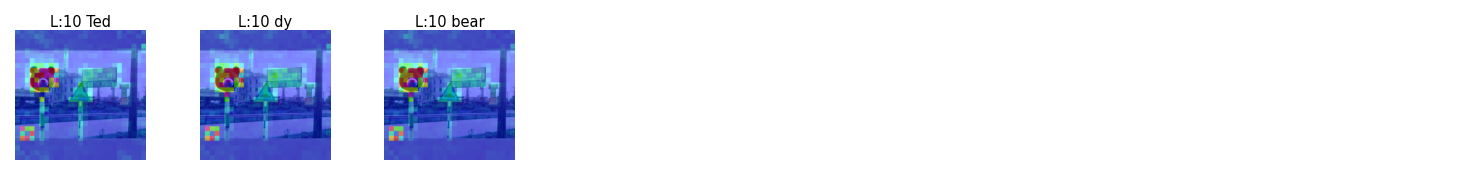

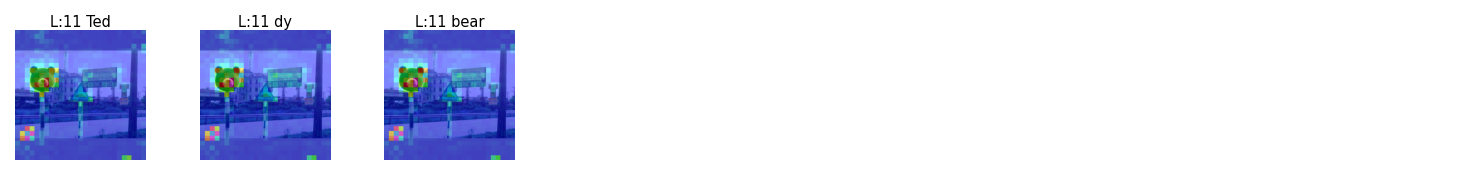

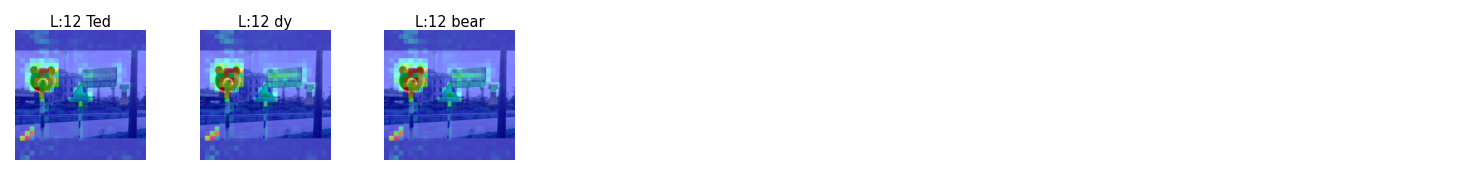

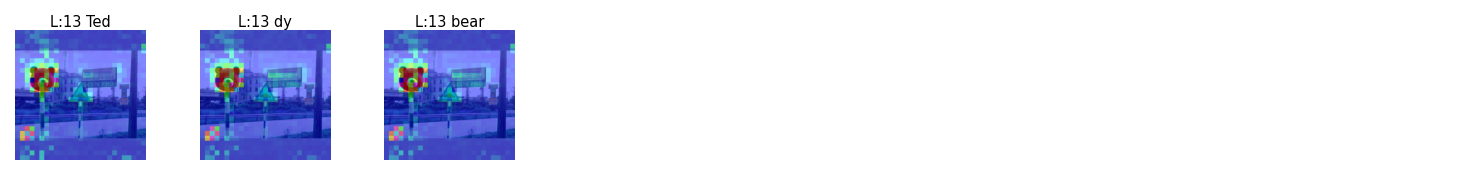

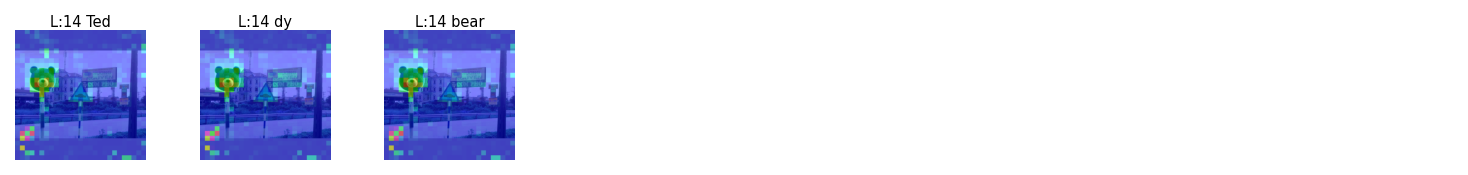

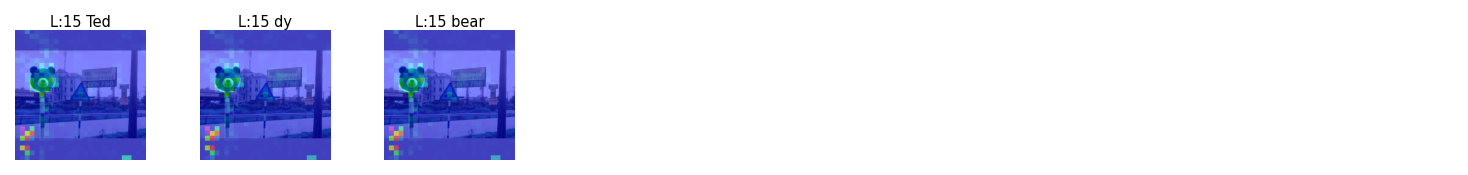

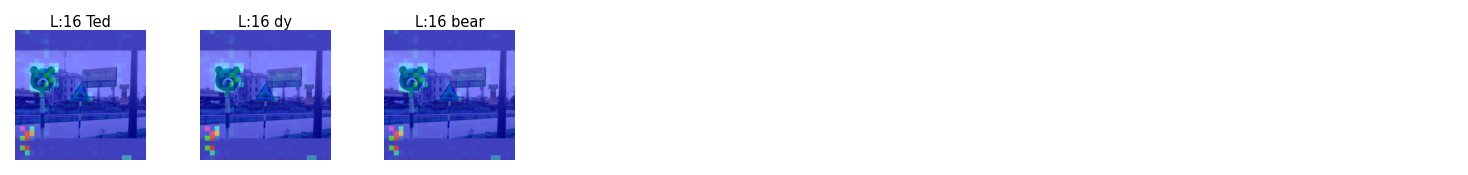

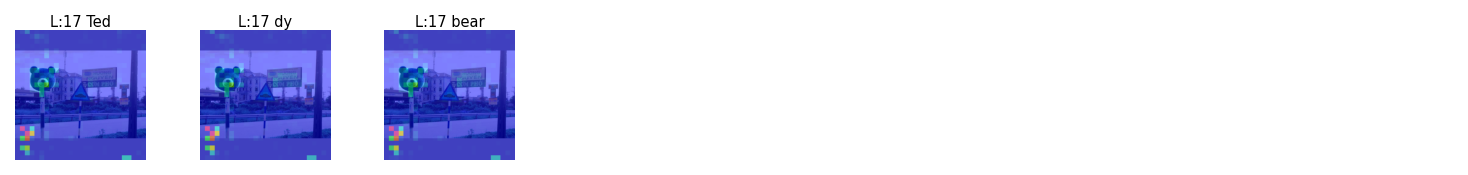

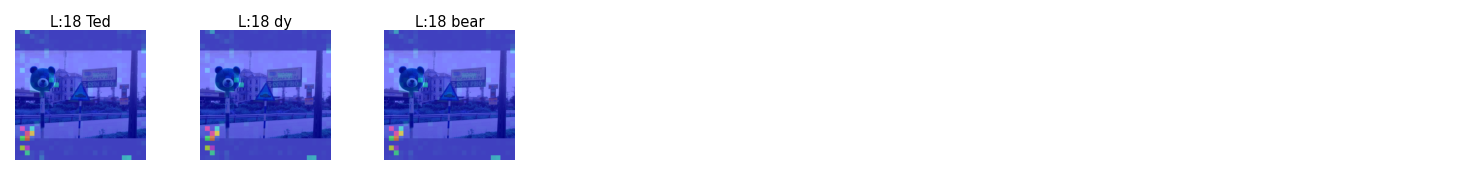

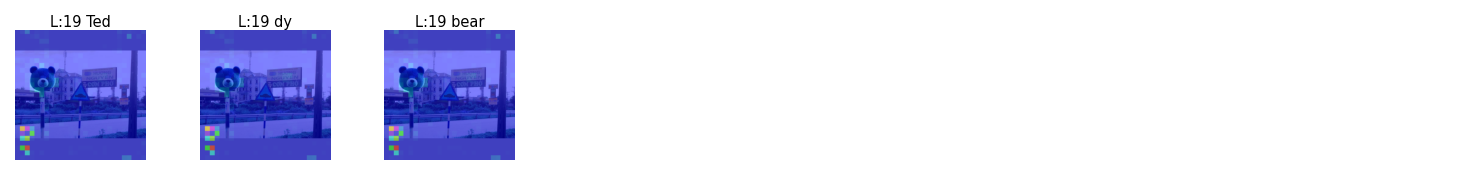

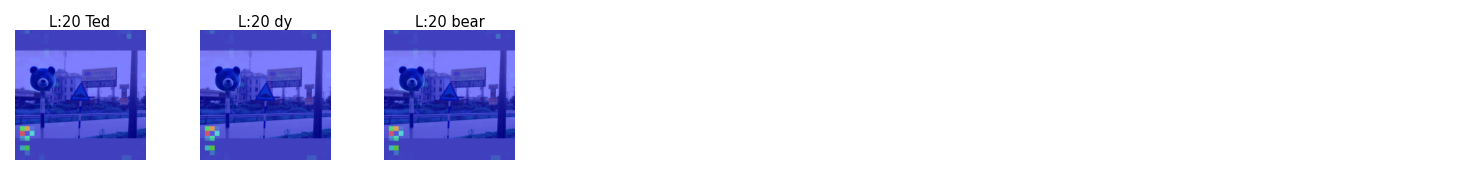

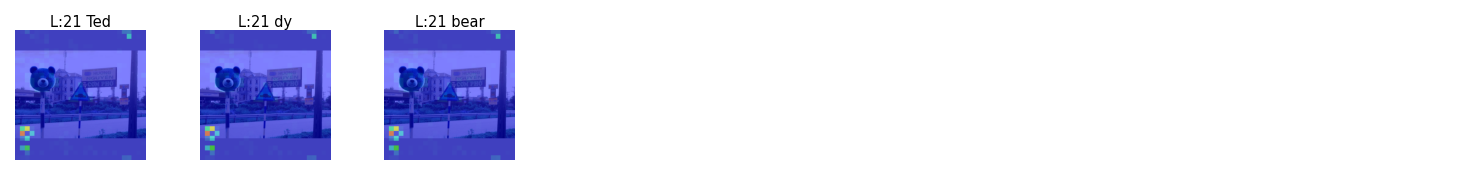

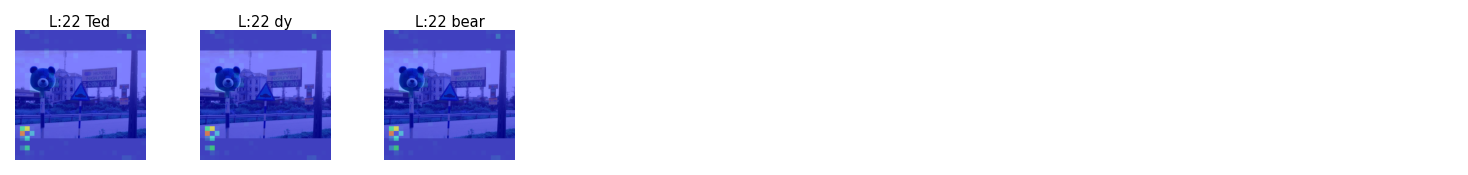

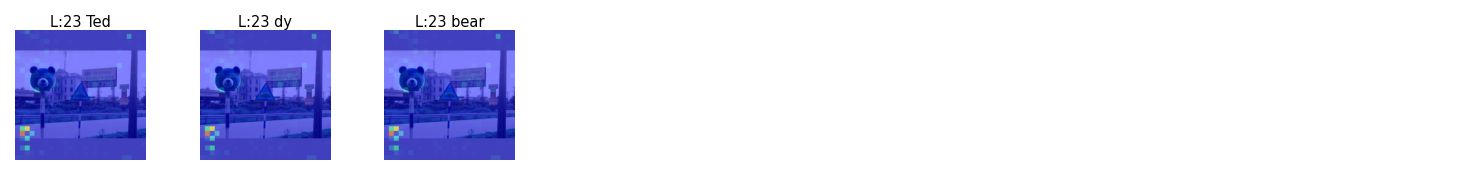

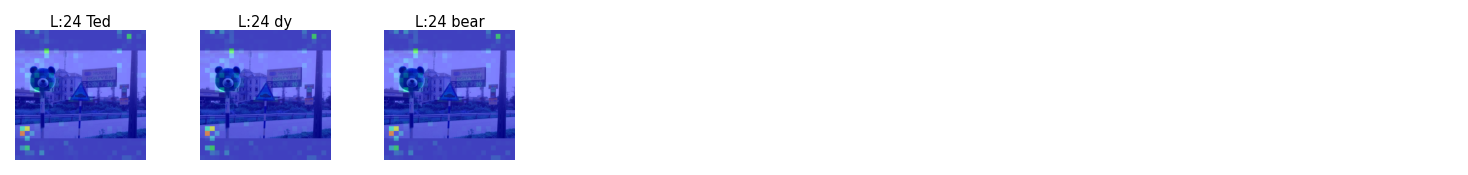

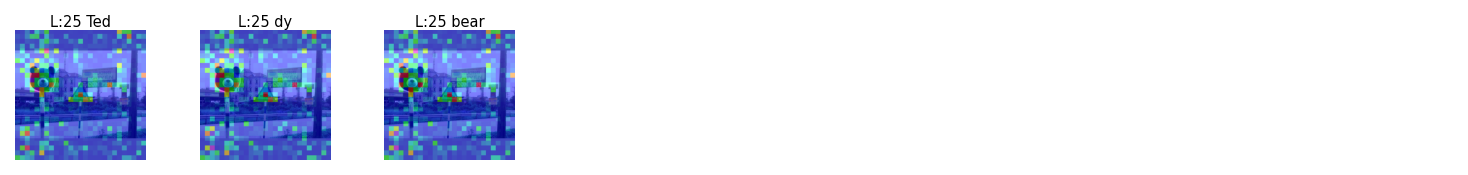

In [ ]:
# ===> Connect with the vision encoder attention for image visualization

# The attention matrix `vis_attn_matrix` will have shape (N, N),
# where N is the number of vision tokens/patches.
# - `all_prev_layers=True`: averages attention across all layers up to the selected layer.
# - `all_prev_layers=False`: only uses the selected layer's attention.

# Retrieve the grid size of patches from the vision tower
grid_size = model.get_vision_tower().num_patches_per_side
num_image_per_row = 8  # Number of images per row in the visualization grid
image_ratio = image_sizes[0] / image_sizes[1]  # Aspect ratio of the input image
output_token_len = output_token_len - 1  # Adjust output token length

# ===> Loop through vision encoder layers to visualize attention maps
for layer in range(0, 26):
    # Aggregate the attention weights from the vision transformer
    vis_attn_matrix = aggregate_vit_attention_subtract_avg(
        attn=att_split,
        attn_avg=avg_mat,
        select_layer=layer,
        all_prev_layers=False
    )

    # Determine the number of rows for the subplot grid
    num_rows = output_token_len // num_image_per_row + (1 if output_token_len % num_image_per_row != 0 else 0)

    # Create a grid for visualizing attention heatmaps
    fig, axes = plt.subplots(
        num_rows, num_image_per_row,
        figsize=(10, (10 / num_image_per_row) * image_ratio * num_rows),
        dpi=150
    )
    plt.subplots_adjust(wspace=0.05, hspace=0.2)

    # Define whether to overlay attention maps on the image
    vis_overlayed_with_attn = True
    output_token_inds = list(range(output_token_start, output_token_end))

    # ===> Process each output token to generate attention maps
    for i, ax in enumerate(axes.flatten()):
        if i >= output_token_len:  # Handle cases where there are more axes than tokens
            ax.axis("off")
            continue

        # Extract attention weights over vision tokens for the current output token
        target_token_ind = output_token_inds[i]
        attn_weights_over_vis_tokens = llm_attn_matrix[target_token_ind][vision_token_start:first_patch_end]
        attn_weights_over_vis_tokens = attn_weights_over_vis_tokens / attn_weights_over_vis_tokens.sum()

        # Compute per-patch attention over the image
        attn_over_image = []
        for weight, vis_attn in zip(attn_weights_over_vis_tokens, vis_attn_matrix):
            vis_attn = vis_attn.reshape(grid_size, grid_size)  # Reshape to 2D patch grid
            attn_over_image.append(vis_attn * weight)
        attn_over_image = torch.stack(attn_over_image).sum(dim=0)
        attn_over_image = attn_over_image / attn_over_image.max()  # Normalize attention map

        # Interpolate the attention map to match image size
        attn_over_image = F.interpolate(
            attn_over_image.unsqueeze(0).unsqueeze(0),
            size=image.size,
            mode='nearest'  # Use 'nearest' for preserving attention structure
            # mode='bicubic',
            # align_corners=False
        ).squeeze()

        # Convert the original image to NumPy format and overlay attention heatmap
        np_img = np.array(image)[:, :, ::-1]  # Convert from RGB to BGR (OpenCV format)
        img_with_attn, heatmap = show_mask_on_image(np_img, attn_over_image.numpy())

        # Display the attention map or overlayed image
        ax.imshow(heatmap if not vis_overlayed_with_attn else img_with_attn)

        # Set plot title with token information
        ax.set_title(
            f'L:{layer} ' + tokenizer.decode(outputs["sequences"][0][i], add_special_tokens=False).strip(),
            fontsize=7,
            pad=1
        )
        ax.axis("off")  # Hide axes for clarity

    # Adjust layout and show the visualization
    plt.tight_layout()
    plt.show()

In [4]:
# Clearing GPU Memory and Garbage Collection

import gc

# Delete unnecessary variables to free memory
del outputs

# Force garbage collection to release unused objects
gc.collect()

# Clear the CUDA cache to free GPU memory
Clearing GPU Memory and Garbage Collectiontorch.cuda.empty_cache()

NameError: name 'outputs' is not defined